In [2]:
import os
import sys
import time
from window_adata import *
import numpy as np
import pandas as pd 
import pickle
import anndata
import scanpy as sc
import pytorch_lightning as pl
import matplotlib.pyplot as plt
import scprep as scp
import anndata as ad
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

from tqdm import tqdm
from scipy import stats
from scipy.stats import pearsonr, spearmanr
from torch.utils.data import DataLoader
from pytorch_lightning.loggers import TensorBoardLogger
from copy import deepcopy as dcp
from collections import defaultdict as dfd
from sklearn.metrics import adjusted_rand_score as ari_score
from sklearn.metrics.cluster import normalized_mutual_info_score as nmi_score
from matplotlib.image import imread
from scanpy import read_visium, read_10x_mtx
from PIL import ImageFile, Image
ImageFile.LOAD_TRUNCATED_IMAGES = True
Image.MAX_IMAGE_PIXELS = None
from anndata import read as read_h5ad
from anndata import (
    AnnData,
    read_csv,
    read_text,
    read_excel,
    read_mtx,
    read_loom,
    read_hdf,)

In [3]:
# Integrate two visium datasets
data_dir1 = "./Alex_NatGen_6BreastCancer/"
data_dir2 = "./breast_cancer_10x_visium/"

samps1 = ["1142243F", "CID4290", "CID4465", "CID44971", "CID4535", "1160920F"]
samps2 = ["block1", "block2", "FFPE"]

sampsall = samps1 + samps2
samples1 = {i:data_dir1 + i for i in samps1}
samples2 = {i:data_dir2 + i for i in samps2}

# Marker gene list
gene_list = ["COX6C","TTLL12", "HSP90AB1", "TFF3", "ATP1A1", "B2M", "FASN", "SPARC", "CD74", "CD63", "CD24", "CD81"]

# # Load windowed dataset
import pickle
with open('10x_visium_dataset_without_window.pickle', 'rb') as f:
    adata_dict0 = pickle.load(f)
    
# Define the gridding size
sizes = [4000 for i in range(len(adata_dict0))]

# Split tiles into smaller patches according to gridding size
adata_dict = window_adata(adata_dict0, sizes)
# del adata_dict0

Windowing 1142243F
246
216
222
185
77
247
246
255
247
93
246
247
255
245
94
247
246
255
238
88
130
135
132
140
55
Total:  4787
Windowing CID4290
793
576
1001
344
Total:  2714
Windowing CID4465
345
258
149
558
Total:  1310
Windowing CID44971
491
462
339
30
Total:  1322
Windowing CID4535
564
232
632
3
Total:  1431
Windowing 1160920F
210
251
251
239
83
226
255
232
240
102
231
230
246
247
99
238
246
247
255
93
144
147
164
160
60
Total:  4896
Windowing block1
139
205
219
185
10
169
246
247
255
16
189
230
205
233
0
197
156
241
228
0
72
106
129
124
0
Total:  3801
Windowing block2
224
247
246
229
208
246
247
231
243
207
211
196
221
195
254
205
81
97
108
92
Total:  3988
Windowing FFPE
50
190
188
79
0
169
219
216
189
0
182
215
201
192
0
68
138
159
63
0
0
1
0
0
0
Total:  2519


In [17]:
# For training
from data_Regclass import ViT_Anndata

def LOOCV_trdataset_wrap(fold = 0):
    test_sample = sampsall[fold] 
    val_sample = list(set(sampsall)-set(test_sample))[:2]
    train_sample = list(set(sampsall)-set(val_sample))
    

    tr_name = list(set([i for i in list(adata_dict.keys()) for tr in train_sample if tr in i]))
    val_name = list(set([i for i in list(adata_dict.keys()) for val in val_sample if val in i]))

    trainset = ViT_Anndata(adata_dict = adata_dict, train_set = tr_name, gene_list = gene_list, train=True, flatten=False, ori=True, prune='NA', neighs=4, )
    valset = ViT_Anndata(adata_dict = adata_dict, train_set = val_name, gene_list = gene_list, train=True, flatten=False, ori=True, prune='NA', neighs=4, )

    print("LOADED TRAINSET")
    train_loader = DataLoader(trainset, batch_size=1, shuffle=True)
    val_loader = DataLoader(valset, batch_size=1, shuffle=True)
    return train_loader, val_loader

# For testing
def LOOCV_tedataset_wrap(fold = 0):
    test_sample = sampsall[fold]
    print(f"Test sample: {test_sample}")
    test_sample_orig = sampsall[fold] # Split one sample as test sample
    te_name = list(set([i for i in list(adata_dict0.keys()) if test_sample in i]))
    testset = ViT_Anndata(adata_dict = adata_dict0, train_set = te_name, gene_list = gene_list, train=True, flatten=False, ori=True, prune='NA', neighs=4, )
    test_loader = DataLoader(testset, batch_size=1, shuffle=False)
    return test_loader
    
def get_R(data1,data2,dim=1,func=pearsonr):
    adata1=data1.X
    adata2=data2.X
    r1,p1=[],[]
    for g in range(data1.shape[dim]):
        if dim==1:
            r,pv=func(adata1[:,g],adata2[:,g])
        elif dim==0:
            r,pv=func(adata1[g,:],adata2[g,:])
        r1.append(r)
        p1.append(pv)
    r1=np.array(r1)
    p1=np.array(p1)
    return r1,p1


In [18]:
import gc
import os
import time
import random
import torch
import numpy as np
import pandas as pd
import scanpy as sc
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
import torchvision.transforms as tf
import warnings
warnings.filterwarnings("ignore")

from torch.nn import init
from easydl import *
from anndata import AnnData
from torch import nn, einsum
from scipy.stats import pearsonr
from torch.autograd import Function
from torch.autograd import Variable
from torch.autograd.variable import *
from einops import rearrange, repeat
from einops.layers.torch import Rearrange
from collections import defaultdict
from scipy.stats import pearsonr
from torch.utils.data import DataLoader
from copy import deepcopy as dcp
from collections import defaultdict as dfd
from sklearn.metrics import adjusted_rand_score as ari_score
from sklearn import metrics
from sklearn.metrics.cluster import normalized_mutual_info_score as nmi_score


from HIST2ST import *
from tqdm import tqdm
from scipy.stats import pearsonr,spearmanr
from torch.utils.data import DataLoader
from pytorch_lightning.loggers import TensorBoardLogger
from copy import deepcopy as dcp
from collections import defaultdict as dfd
from sklearn.metrics import adjusted_rand_score as ari_score
from sklearn.metrics.cluster import normalized_mutual_info_score as nmi_score
from pytorch_lightning import seed_everything
from pytorch_lightning.callbacks.early_stopping import EarlyStopping


def setup_seed(seed):
    import random
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)

    
def MLP(n_layers, n_units):
    """
    num_layers=[2,3,4]
    num_units=[200,400,600,800,1000]
    Dropout_rate=0.2
    """
    layers = []
    in_size =1024
    for i in range(n_layers):
        layers.append(nn.Linear(in_size, n_units))
        layers.append(nn.ReLU())
        layers.append(nn.Dropout(p=0.2))
        in_size = n_units
    layers.append(nn.Linear(in_size, 2))
    layers.append(nn.Softmax(dim=1))
    return nn.Sequential(*layers)

class Regclass(pl.LightningModule):
    def __init__(self, zinb=0.25, nb=False, bake=5, lamb=0.5, gamma=0,
                 learning_rate=1e-5, seed=12000, n_layer=4, n_units=800,
                ):
        super().__init__()
        # self.save_hyperparameters()
        self.learning_rate = learning_rate
        self.zinb=zinb
        self.nb=nb
        self.bake=bake
        self.lamb=lamb
        self.gamma=gamma
        self.seed=seed
        self.tf=tf.Compose([
            tf.RandomGrayscale(0.1),
            tf.RandomRotation(90),
            tf.RandomHorizontalFlip(0.2),
        ])
        self.Regressor= Hist2ST(
                    depth1=2, depth2=8,depth3=4,n_genes=12, 
                    kernel_size=5, patch_size=7,
                    heads=16, channel=32, dropout=0.2,
                    zinb=0.25, nb=False, n_pos=128,
                    bake=5, lamb=0.5,)
        self.classifier = MLP(n_layer,n_units)

    def forward(self, patches, centers, adj):
        x,extra,h = self.Regressor(patches, centers, adj)
        cell_type_prob = self.classifier(h)
        return x,extra,h,cell_type_prob
    
    """Helper function"""
    def aug(self,patch,center,adj):
        bake_x=[]
        for i in range(self.bake):
            new_patch=self.Regressor.tf(patch.squeeze(0)).unsqueeze(0)
            x,_,h =self.Regressor(new_patch,center,adj,True)
            bake_x.append((x.unsqueeze(0),h.unsqueeze(0)))
        return bake_x

    def distillation(self,bake_x):
        new_x,coef=zip(*bake_x)
        coef=torch.cat(coef,0)
        new_x=torch.cat(new_x,0)
        coef=F.softmax(coef,dim=0)
        new_x=(new_x*coef).sum(0)
        return new_x
    
    # Training steps 
    def training_step(self, batch, batch_idx):
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
        patch, center, exp, adj, label, oris, sfs, *_ = batch
        adj=adj.squeeze(0)
        exp=exp.squeeze(0)
        
        # Model inference 
        gene_exp, extra, ft, cell_type_prob = self(patch, center, adj)
        
        # Regression loss 
        mse_loss = F.mse_loss(gene_exp, exp)
        self.log('mse_loss', mse_loss, on_epoch=True, prog_bar=True, logger=True)
        
        # Classification loss  
        if torch.all(label.eq(torch.full((label.shape), 6).to(device))):
            cross_entropy = 0.0
            cross_entropy = torch.tensor(cross_entropy,requires_grad=True).to(device)
        else:
            cell_type = cell_type_prob.argmax(dim=1, keepdim=True)
            cell_type, label = cell_type.view(-1), label.view(-1)
            cross_entropy = nn.CrossEntropyLoss()(cell_type_prob,label.long())
            # Calculate accuracy
            accuracy = cell_type.eq(label.view_as(cell_type)).float().mean()
            self.log('train_acc', accuracy, on_epoch=True, prog_bar=True, logger=True)
            # Calculate F1 score
            f1 = metrics.f1_score(label.detach().cpu(), cell_type.squeeze(0).detach().cpu())
            self.log('train_F1', f1, on_epoch=True, prog_bar=True, logger=True)
        
        # Data augmentation loss 
        bake_loss=0
        if self.bake>0:
            bake_x=self.aug(patch,center,adj)
            new_pred=self.distillation(bake_x)
            bake_loss+=F.mse_loss(new_pred,gene_exp)
            self.log('bake_loss', bake_loss, on_epoch=True, prog_bar=True, logger=True)
        
        # Distribution loss  
        zinb_loss=0
        if self.zinb>0:
            if self.nb:
                r,p=extra
                zinb_loss = NB_loss(oris.squeeze(0),r,p)
            else:
                m,d,p=extra
                zinb_loss = ZINB_loss(oris.squeeze(0),m,d,p,sfs.squeeze(0))
            self.log('zinb_loss', zinb_loss,on_epoch=True, prog_bar=True, logger=True)

        """ Total loss """
        loss = mse_loss + self.zinb*zinb_loss + self.lamb*bake_loss + self.gamma*cross_entropy
        # loss = cross_entropy
        
        self.log('Train_loss', loss, on_epoch=True, prog_bar=True, logger=True) 
        return loss
    
    def validation_step(self, batch, batch_idx):
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
        patch, center, exp, adj, label, oris, sfs, *_ = batch
        adj=adj.squeeze(0)
        exp=exp.squeeze(0)
        
        """Model inference"""
        gene_exp, extra, ft, cell_type_prob = self(patch, center, adj)
        
        """Regression loss"""
        mse_loss = F.mse_loss(gene_exp, exp)
        self.log('val_loss', mse_loss, on_epoch=True, prog_bar=True, logger=True)
        
        """Pearson correlation coeficient"""
        adata1 = ad.AnnData(gene_exp.cpu().detach().numpy())
        adata2 = ad.AnnData(exp.cpu().detach().numpy())
        R=get_R(adata1,adata2)[0]
        mean_pcc=np.nanmean(R)
        self.log('mean_PCC', mean_pcc, on_epoch=True, prog_bar=True, logger=True)
        
        """Classification loss"""
        if torch.all(label.eq(torch.full((label.shape), 6).to(device))):
            cross_entropy = 0.0
            cross_entropy = torch.tensor(cross_entropy,requires_grad=True).to(device)
        else:
            cell_type = cell_type_prob.argmax(dim=1, keepdim=True)
            cell_type, label = cell_type.view(-1).squeeze(), label.view(-1).squeeze()
            cls_loss = nn.CrossEntropyLoss()
            cross_entropy = cls_loss(cell_type_prob,label.long())
            accuracy = cell_type.eq(label.view_as(cell_type)).float().mean()
            self.log('val_accuracy', accuracy, on_epoch=True, prog_bar=True, logger=True)
            self.log('val_cross_entropy', cross_entropy, on_epoch=True, prog_bar=True, logger=True)
            
        return mean_pcc
            
    def test_step(self, batch, batch_idx):
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
        patch, center, exp, adj, label, oris, sfs, *_ = batch
        adj, exp =adj.squeeze(0), exp.squeeze(0)
        
        # Model inference 
        gene_exp, extra, ft, cell_type_prob = self(patch, center, adj)
        
        # Regression loss 
        mse_loss = F.mse_loss(gene_exp, exp)
        self.log('test_loss', mse_loss, on_epoch=True, prog_bar=True, logger=True)
        
        # Pearson correlation coeficient 
        adata1 = ad.AnnData(gene_exp.cpu().detach().numpy())
        adata2 = ad.AnnData(exp.cpu().detach().numpy())
        R=get_R(adata1,adata2)[0]
        mean_pcc=np.nanmean(R)
        self.log('test_mean_PCC', mean_pcc, on_epoch=True, prog_bar=True, logger=True)
 
        # Classification loss 
        if torch.all(label.eq(torch.full((label.shape), 6).to(device))):
            cross_entropy = 0.0
            cross_entropy = torch.tensor(cross_entropy,requires_grad=True).to(device)
        else:
            # Accuracy  
            cell_type = cell_type_prob.argmax(dim=1, keepdim=True)
            cell_type, label = cell_type.view(-1).squeeze(), label.view(-1).squeeze()
            accuracy = cell_type.eq(label.view_as(cell_type)).float().mean()
            self.log('test_accuracy', accuracy, on_epoch=True, prog_bar=True, logger=True)
            
            cell_type_prob = cell_type_prob.squeeze()
            predictions, label = cell_type_prob.detach().cpu().numpy(), label.detach().cpu().numpy()
            
            #  F1 Score  
            # Calculate F1 score
            f1 = metrics.f1_score(label, cell_type.squeeze(0).detach().cpu())
            self.log('te_F1_score', f1, on_epoch=True, prog_bar=True, logger=True)
            
            # ROC curve  
            # Compute the false positive rate (FPR), true positive rate (TPR), and thresholds
            fpr, tpr, thresholds = metrics.roc_curve(label, predictions[:, 1])
            # Compute the area under the ROC curve (AUC)
            auc_score = metrics.auc(fpr, tpr)

            # Plot the ROC curve
            plt.plot(fpr, tpr, label=f"AUC = {auc_score:.2f}")
            plt.plot([0, 1], [0, 1], 'k--')
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title('Receiver Operating Characteristic (ROC) Curve')
            plt.legend(loc='lower right')
            plt.show()     
            
            # Confusion matrix
            metrics.ConfusionMatrixDisplay.from_predictions(label, cell_type.squeeze(0).detach().cpu())
            plt.title(f'Confusion Matrix')
            plt.show()  
            
    def configure_optimizers(self):
        # self.hparams available because we called self.save_hyperparameters()
        optim=torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        optim_dict = {'optimizer': optim}
        return optim_dict
    


[easydl] tensorflow not available!


Loading imgs...
Loading imgs...
LOADED TRAINSET
Test sample: 1142243F
Loading imgs...


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type       | Params
------------------------------------------
0 | Regressor  | Hist2ST    | 72.8 M
1 | classifier | Sequential | 2.7 M 
------------------------------------------
75.5 M    Trainable params
0         Non-trainable params
75.5 M    Total params
301.982   Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


Epoch 0: 100%|██████████| 97/97 [00:28<00:00,  3.44it/s, mse_loss_step=0.434, train_acc_step=0.290, train_F1_step=0.450, bake_loss_step=5.97e-5, zinb_loss_step=11.00, Train_loss_step=3.190]  
Validation: 0it [00:00, ?it/s]
Epoch 0: 100%|██████████| 97/97 [00:30<00:00,  3.22it/s, mse_loss_step=0.434, train_acc_step=0.290, train_F1_step=0.450, bake_loss_step=5.97e-5, zinb_loss_step=11.00, Train_loss_step=3.190, val_loss=0.669, mean_PCC=0.011, val_accuracy=0.161, val_cross_entropy=0.694, mse_loss_epoch=2.010, train_acc_epoch=0.300, train_F1_epoch=0.0343, bake_loss_epoch=0.000108, zinb_loss_epoch=11.00, Train_loss_epoch=4.970]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 97/97 [00:31<00:00,  3.10it/s, mse_loss_step=0.434, train_acc_step=0.290, train_F1_step=0.450, bake_loss_step=5.97e-5, zinb_loss_step=11.00, Train_loss_step=3.190, val_loss=0.669, mean_PCC=0.011, val_accuracy=0.161, val_cross_entropy=0.694, mse_loss_epoch=2.010, train_acc_epoch=0.300, train_F1_epoch=0.0343, bake_loss_epoch=0.000108, zinb_loss_epoch=11.00, Train_loss_epoch=4.970]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Testing DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

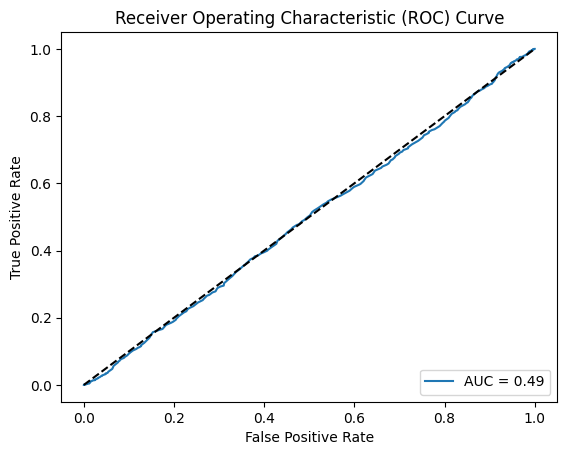

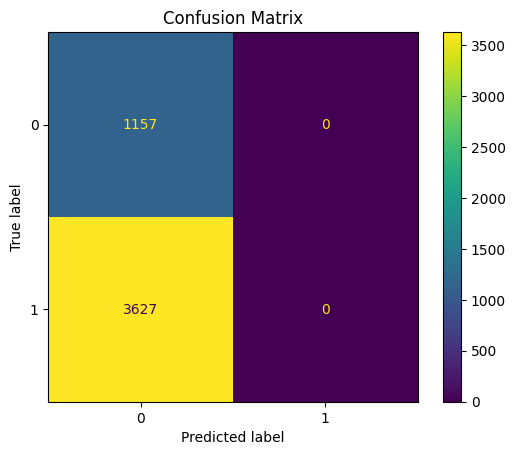

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  1.57it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        te_F1_score        │            0.0            │
│       test_accuracy       │    0.24184782803058624    │
│         test_loss         │    0.7238608002662659     │
│       test_mean_PCC       │  -0.00038066182069633746  │
└───────────────────────────┴───────────────────────────┘

Training time:  0.0348272536860572  hours


In [19]:
# For training only
import gc
from pytorch_lightning import seed_everything
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
import time

start_time = time.time()

# Training loops
seed=12000
epochs=1
fold=0
gamma=0.5
# Load dataset 
train_loader, val_loader = LOOCV_trdataset_wrap(fold=fold)
test_loader = LOOCV_tedataset_wrap()

# Define model 
model = Regclass(gamma=gamma)
setup_seed(seed)

# Setup trainer 
logger = pl.loggers.CSVLogger("logs", name=f"./{gamma}_fold{fold}")
trainer = pl.Trainer(accelerator='auto', callbacks=[EarlyStopping(monitor='val_cross_entropy',mode='min')], 
                     max_epochs=epochs, logger=False)
trainer.fit(model, train_loader, val_loader)
trainer.test(model, test_loader)

# Save model and clean memory 

# torch.save(model.state_dict(),f"./model/Regclass-gamma{gamma}-OOD.ckpt")
gc.collect()
end_time = time.time()
execution_time = end_time - start_time
print("Training time: ", execution_time/3600, " hours")
del model, train_loader, val_loader, test_loader
